# ObJAX Tutorial

In [1]:
# Load the dependencies


## TEMPORARY HACK
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import sys
sys.path.append("../../")
## </hack>

import numpy as np
import jax
import jax.numpy as jn
import objax

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the MNIST dataset

import tensorflow.keras as keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# ObJAX is like Torch, and puts the channel BEFORE the height and width.
# The data starts out as (dataset_size, height=28, width=28)
# We're going to make it (dataset_size, channels=1, height=28, width=28)
x_train = x_train[:,None,:,:]/255.0
x_test = x_test[:,None,:,:]/255.0

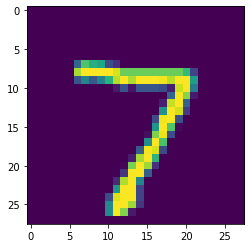

In [3]:
# Check that we've loaded the data properly.
# Print out the first channel of the first image in the test set
plt.imshow(x_test[0,0])

In [4]:
# Create a classifier.
# For now, we're going to start with three convolutional layers,
# with ReLU activations after each

# To compute the final predictions, we use a 1D convolution
# converting the input to (batch_size, 10, 28, 28)
# then we take the mean over the 28x28 image
# (instead of a big fully-connected layer)

def conv_relu_pool(in_layers, out_layers, pool=True):
    ops = [objax.nn.Conv2D(in_layers, out_layers, 5),
            objax.functional.relu]
    if pool:
        ops.append(lambda x: objax.functional.average_pool_2d(x, size=2, strides=1))
    return ops

model = objax.nn.Sequential(conv_relu_pool(1, 32) + \
                            conv_relu_pool(32, 32) + \
                            conv_relu_pool(32, 64) + \
                            [objax.nn.Conv2D(64, 10, 1),
                             lambda x: x.mean((2,3))])

# Print the model out to show what we'll be optimizing
model.vars().print()

(Sequential)[0](Conv2D).b       32 (32, 1, 1)
(Sequential)[0](Conv2D).w      800 (5, 5, 1, 32)
(Sequential)[3](Conv2D).b       32 (32, 1, 1)
(Sequential)[3](Conv2D).w    25600 (5, 5, 32, 32)
(Sequential)[6](Conv2D).b       64 (64, 1, 1)
(Sequential)[6](Conv2D).w    51200 (5, 5, 32, 64)
(Sequential)[9](Conv2D).b       10 (10, 1, 1)
(Sequential)[9](Conv2D).w      640 (1, 1, 64, 10)
+Total(8)                    78378


In [5]:
# Create the optimizer to train the model.
# We'll start with Adam as a good baseline optimizer.
# We pass in the model variables to optimize

opt = objax.optimizer.Adam(model.vars())

# Next, we'll create our prediction function 
# We compute the softmax of the model predictions,
# and wrap this with objax.Jit in order to run the JAX jit over everything.
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

In [6]:
# Define the loss function by generating model predictions, 
# and then taking the sparse softmax cross entropy predictions

def loss(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

# Next, we're going to call objax.GradValues.
# This returns a *function* that will return a tuple:
# grad: the gradient of the loss on the input with respect to the model parameters
# values: the values of the loss function on each input

gv = objax.GradValues(loss, model.vars())

# Finally, we create our function that will run the neural network training

def train_op_nojit(x, y):
    # Get the gradients and the losses at the current input
    g, v = gv(x, y)
    
    # Then, run the optimizer passing in the learning rate and the gradients
    opt(lr=0.002, grads=g)
    
    # Finally, return the loss on these examples
    return v

# Again we JIT the train_op so that it runs more quickly.
train_op = objax.Jit(train_op_nojit, model.vars() + opt.vars())

In [7]:
# Train for just ten epochs, because MNIST is simple enough for that.
# This should be fast if you have a GPU attached to JAX
# otherwise it will take a few minutes on a CPU
def train_epoch(batch_size=50):    
    # We'll save the losses after each minibatch
    losses = []
    
    # Iterate over the training data, batch_size examples at a time
    for x_batch, y_batch in zip(x_train.reshape((-1, batch_size, 1, 28, 28)), y_train.reshape((-1, batch_size))):
        # And run the training op on each minibatch
        losses.append(train_op(x_batch, y_batch))

    return np.mean(losses)

for i in range(10):
    print('loss', train_epoch())
    
def compute_accuracy():
    # Compute the final predictions on the test data
    test_predictions = [predict(test_batch).argmax(1) for test_batch in x_test.reshape((-1, 50, 1, 28, 28))]
    return np.mean(y_test == np.array(test_predictions).flatten())

print('model accuracy', compute_accuracy())

loss 1.0557986
loss 0.18019806
loss 0.11240303
loss 0.087404795
loss 0.07405012
loss 0.065644935
loss 0.059288323
loss 0.053326696
loss 0.05036633
loss 0.04767788
model accuracy 0.9756


# Training a bigger model

In [8]:
# Okay, now with a simple and tiny baseline model trained, let's train a
# bigger model that we hope can do better.
# Then, we'll try to prune it down to be just as small, but with better accuracy.

model = objax.nn.Sequential(conv_relu_pool(1, 32, pool=False) + \
                            conv_relu_pool(32, 64) + \
                            conv_relu_pool(64, 64, pool=False) + \
                            conv_relu_pool(64, 128) + \
                            [objax.nn.Conv2D(128, 10, 1),
                             lambda x: x.mean((2,3))])
model.vars().print()
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())


def loss_with_wd(x, label):
    logit = model(x)
    xe_loss = objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()
    wd_loss = sum(jn.abs(v.value).sum() for k,v in model.vars().items() if k.endswith('.w'))
    return xe_loss + wd_loss * 1e-5

# Redefine the gradient and train ops

opt = objax.optimizer.Adam(model.vars())
gv = objax.GradValues(loss_with_wd, model.vars())
train_op = objax.Jit(train_op_nojit, model.vars() + opt.vars())

(Sequential)[0](Conv2D).b        32 (32, 1, 1)
(Sequential)[0](Conv2D).w       800 (5, 5, 1, 32)
(Sequential)[2](Conv2D).b        64 (64, 1, 1)
(Sequential)[2](Conv2D).w     51200 (5, 5, 32, 64)
(Sequential)[5](Conv2D).b        64 (64, 1, 1)
(Sequential)[5](Conv2D).w    102400 (5, 5, 64, 64)
(Sequential)[7](Conv2D).b       128 (128, 1, 1)
(Sequential)[7](Conv2D).w    204800 (5, 5, 64, 128)
(Sequential)[10](Conv2D).b       10 (10, 1, 1)
(Sequential)[10](Conv2D).w     1280 (1, 1, 128, 10)
+Total(10)                   360778


In [10]:
# And train!
for i in range(10):
    random_shuffle = np.arange(x_train.shape[0])
    np.random.shuffle(random_shuffle)
    x_train = x_train[random_shuffle]
    y_train = y_train[random_shuffle]
    print('loss', train_epoch(batch_size=200))
    
print('model accuracy', compute_accuracy())
for k,v in model.vars().items():
    if k.endswith('.w'):
        print("Small weight ratio on layer", k, (jn.abs(v.value) < 1e-2).mean())

loss 0.10089671
loss 0.09586551
loss 0.09251984
loss 0.08294758
loss 0.079793945
loss 0.07640481
loss 0.074100986
loss 0.07067666
loss 0.06935732
loss 0.06614431
model accuracy 0.9907
Small weight ratio on layer (Sequential)[0](Conv2D).w 0.055
Small weight ratio on layer (Sequential)[2](Conv2D).w 0.83347654
Small weight ratio on layer (Sequential)[5](Conv2D).w 0.9338476
Small weight ratio on layer (Sequential)[7](Conv2D).w 0.84509766
Small weight ratio on layer (Sequential)[10](Conv2D).w 0.165625


Loss 0.089355305
Loss 0.083341315
Loss 0.07977875
Loss 0.07744293
Loss 0.075916454


In [186]:
model.vars().print()

(Sequential)[0](Conv2D).b        32 (32, 1, 1)
(Sequential)[0](Conv2D).w       800 (5, 5, 1, 32)
(Sequential)[2](Conv2D).b        64 (64, 1, 1)
(Sequential)[2](Conv2D).w     51200 (5, 5, 32, 64)
(Sequential)[5](Conv2D).b        64 (64, 1, 1)
(Sequential)[5](Conv2D).w    102400 (5, 5, 64, 64)
(Sequential)[7](Conv2D).b       128 (128, 1, 1)
(Sequential)[7](Conv2D).w    204800 (5, 5, 64, 128)
(Sequential)[10](Conv2D).b       10 (10, 1, 1)
(Sequential)[10](Conv2D).w     1280 (1, 1, 128, 10)
+Total(10)                   360778
